# Visualizing prob-maps

In [2]:
import pickle
import itertools
import glob
import gc

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm, trange
#from statsmodels.stats.proportion import proportion_confint

from pyecsca.ec.mult import *
from pyecsca.misc.utils import TaskExecutor

from common import *

%matplotlib ipympl

RuntimeError: 'ipympl is not a recognised GUI loop or backend name

## Setup
Setup some plotting and the computations of prob-maps out of the small scalar data and divisors.

In [3]:
# Setup the ticks and colors deterministically.
mult_klasses = sorted(list(set(map(lambda mult: mult.klass, all_mults))), key=lambda klass: klass.__name__)
mult_kwarg_map = {klass: 0 for klass in mult_klasses}
mult_cm_map = {mult: 0 for mult in all_mults}
mult_colors = matplotlib.cm.tab20(range(len(mult_klasses)))
mult_styles = ['-', '--', '-.', ':', (5, (10, 3)), (0, (5, 1)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (3, 10, 1, 10))]
mult_markers = [None, "o", "+", "*", "^"]
colors = {}
styles = {}
markers = {}
for mult in all_mults:
    color = mult_colors[mult_klasses.index(mult.klass) % len(mult_colors)]
    style = mult_styles[mult_kwarg_map[mult.klass] % len(mult_styles)]
    mult_kwarg_map[mult.klass] += 1
    for cm in (None, "gsr", "additive", "multiplicative", "euclidean"):
        mwc = mult.with_countermeasure(cm)
        colors[mwc] = color
        styles[mwc] = style
        markers[mwc] = mult_markers[mult_cm_map[mult] % len(mult_markers)]
        mult_cm_map[mult] += 1

majticks = np.arange(0, 1, 0.1)
minticks = np.arange(0, 1, 0.05)

In [4]:
def divides_any(l: int, small_scalars: set[int]) -> bool:
    for s in small_scalars:
        if s%l==0:
            return True
    return False

def process_small_scalars(scalar_results: MultResults, divisors: set[int]) -> ProbMap:
    result = {}
    for divisor in divisors:
        count = 0
        for smult in scalar_results.multiplications:
            if divides_any(divisor, smult):
                count += 1
        result[divisor] = count / scalar_results.samples
    return ProbMap(result, scalar_results.samples)

def load_chunk(fname: str, divisors: set[int]) -> dict[MultIdent, ProbMap]:
    with open(fname, "rb") as f:
        multiples = pickle.load(f)
        res = {}
        for mult, results in multiples.items():
            res[mult] = process_small_scalars(results, divisors)
    return res

def conf_interval(p: float, samples: int, alpha: float = 0.05) -> tuple[float, float]:
    return proportion_confint(round(p*samples), samples, alpha, method="wilson")

## Divisors
The cell below contains some interesting divisors for distinguishing scalarmults.

In [7]:
def powers_of(k, max_power=20):
    return [k**i for i in range(1, max_power)]

def prod_combine(one, other):
    return [a * b for a, b in itertools.product(one, other)]

small_primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
medium_primes = [211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397]
large_primes = [401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
all_integers = list(range(1, 400))
all_even = list(range(2, 400, 2))
all_odd = list(range(1, 400, 2))
all_primes = small_primes + medium_primes + large_primes

divisor_map = {
    "small_primes": small_primes,
    "medium_primes": medium_primes,
    "large_primes": large_primes,
    "all_primes": all_primes,
    "all_integers": all_integers,
    "all_even": all_even,
    "all_odd": all_odd,
    "powers_of_2": powers_of(2),
    "powers_of_2_large": powers_of(2, 256),
    "powers_of_2_large_3": [i * 3 for i in powers_of(2, 256)],
    "powers_of_2_large_p1": [i + 1 for i in powers_of(2, 256)],
    "powers_of_2_large_m1": [i - 1 for i in powers_of(2, 256)],
    "powers_of_2_large_pmautobus": sorted(set([i + j for i in powers_of(2, 256) for j in range(-5,5) if i+j > 0])),
    "powers_of_3": powers_of(3),
}
divisor_map["all"] = list(sorted(set().union(*[v for v in divisor_map.values()])))
for d, ds in divisor_map.items():
    print(d, len(ds))

small_primes 45
medium_primes 32
large_primes 90
all_primes 167
all_integers 399
all_even 199
all_odd 200
powers_of_2 19
powers_of_2_large 255
powers_of_2_large_3 255
powers_of_2_large_p1 255
powers_of_2_large_m1 255
powers_of_2_large_pmautobus 2530
powers_of_3 19
all 3220


In [5]:
bits = 256
num_workers = 28

Select the mults you want to compute the prob-maps for here as well as a set of divisors. It is good to set `all` here, compute the prob-maps for all the divisors, save them and they continue with visualizing them on subsets of divisors.

## Configuration

In [6]:
selected_mults = all_mults
divisor_name = "all"
kind = "precomp+necessary"
showci = False
selected_divisors = divisor_map[divisor_name]

NameError: name 'divisor_map' is not defined

In [ ]:
# This cell computes the probmaps from the multiplication result chunks. Only do this on small amount of chunks.
# distributions_mults = {}
# files = sorted(glob.glob(f"multiples_{bits}_{kind}_chunk*.pickle"))
# with TaskExecutor(max_workers=num_workers) as pool:
#     for fname in files:
#         pool.submit_task(fname,
#                          load_chunk,
#                          fname, selected_divisors)
#     for fname, future in tqdm(pool.as_completed(), leave=False, total=len(pool.tasks), smoothing=0):
#         if error := future.exception():
#             print(f"Error {fname}, {error}")
#             continue
#         new_distrs = future.result()
#         for mult, prob_map in new_distrs.items():
#             if mult in distributions_mults:
#                 distributions_mults[mult].merge(prob_map)
#             else:
#                 distributions_mults[mult] = prob_map
# Save
# with open(f"{divisor_name}_{kind}_distrs.pickle", "wb") as f:
#     pickle.dump(distributions_mults, f)

In [8]:
# Optionally, load
with open(f"{divisor_name}_{kind}_distrs.pickle", "rb") as f:
    distributions_mults = pickle.load(f)

Now, go over all the divisor sets and visualize them (without the combs) into PNGs in the graphs/ directory.

In [9]:
for mult, probmap in distributions_mults.items():
    for divisor in sorted(divisor_map[divisor_name]):
        if divisor not in probmap.probs:
            print(f"Missing {mult}, {divisor}")
    if probmap.kind is not None and probmap.kind != kind:
        print("Bad kind! Did you forget to load?")

## Plots (nocomb)
Let's visualize all the divisor groups while looking at the multipliers and countermeasures except the comb-like ones.

In [ ]:
for divisor_name in divisor_map:
    plot_mults = list(filter(lambda mult: mult in distributions_mults and mult.klass not in (CombMultiplier, BGMWMultiplier), all_mults_with_ctr))
    print(divisor_name, "nocomb")
    plot_divisors = sorted(divisor_map[divisor_name])
    L = len(plot_divisors)
    N = len(plot_mults)
    x = list(range(L))
    
    fig = plt.figure(figsize=(L/4+10, 24))
    ax = plt.subplot(111)
    
    vals = np.zeros((N, L))
    n_samples = 0
    for i, mult in enumerate(plot_mults):
        probmap = distributions_mults[mult]
        y_values = [probmap[l] for l in plot_divisors]
        vals[i,] = y_values
        ax.plot(x, y_values, color=colors[mult], linestyle=styles[mult], marker=markers[mult], label=str(mult))
        if showci:
            cis = [conf_interval(p, probmap.samples) for p in y_values]
            ci_low = [ci[0] for ci in cis]
            ci_high = [ci[1] for ci in cis]
            ax.fill_between(x, ci_low, ci_high, color="black", alpha=0.1)
        n_samples += probmap.samples
    
    ax.set_title(f"{divisor_name} ({kind})\nSamples(avg): " + str(n_samples//N))
    
    var = np.var(vals, axis=0)
    ax.plot(x, var / np.max(var), label="cross-mult variance (normalized)", ls="--", lw=2, color="black")
    
    ax.set_xlabel("divisors")
    ax.set_ylabel("error probability")
    ax.set_yticks(majticks)
    ax.set_yticks(minticks, minor=True)
    ax.set_xticks(x, plot_divisors, rotation=90)
    
    ax.grid(axis="y", which="major", alpha=0.7)
    ax.grid(axis="y", which="minor", alpha=0.3)
    ax.grid(axis="x", alpha=0.7)
    plt.tight_layout()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 6})
    plt.close()
    fig.savefig(f"graphs/{divisor_name}-{kind}-nocomb{'+ci' if showci else ''}.png", dpi=300);

## Plots (allmults)
Now, lets also do plots with allmults for all divisor groups.

In [ ]:
for divisor_name in divisor_map:
    plot_mults = list(filter(lambda mult: mult in distributions_mults, all_mults_with_ctr))
    print(divisor_name, "allmults")
    plot_divisors = sorted(divisor_map[divisor_name])
    L = len(plot_divisors)
    N = len(plot_mults)
    x = list(range(L))
    
    fig = plt.figure(figsize=(L/4+10, 26))
    ax = plt.subplot(111)
    
    vals = np.zeros((N, L))
    n_samples = 0
    for i, mult in enumerate(plot_mults):
        probmap = distributions_mults[mult]
        y_values = [probmap[l] for l in plot_divisors]
        vals[i,] = y_values
        ax.plot(x, y_values, color=colors[mult], linestyle=styles[mult], marker=markers[mult], label=str(mult))
        if showci:
            cis = [conf_interval(p, probmap.samples) for p in y_values]
            ci_low = [ci[0] for ci in cis]
            ci_high = [ci[1] for ci in cis]
            ax.fill_between(x, ci_low, ci_high, color="black", alpha=0.1)
        n_samples += probmap.samples
    
    ax.set_title(f"{divisor_name} ({kind})\nSamples(avg): " + str(n_samples//N))
    
    var = np.var(vals, axis=0)
    ax.plot(x, var / np.max(var), label="cross-mult variance (normalized)", ls="--", lw=2, color="black")
    
    ax.set_xlabel("divisors")
    ax.set_ylabel("error probability")
    ax.set_yticks(majticks)
    ax.set_yticks(minticks, minor=True)
    ax.set_xticks(x, plot_divisors, rotation=90)
    
    ax.grid(axis="y", which="major", alpha=0.7)
    ax.grid(axis="y", which="minor", alpha=0.3)
    ax.grid(axis="x", alpha=0.7)
    plt.tight_layout()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 6})
    plt.close()
    fig.savefig(f"graphs/{divisor_name}-{kind}-allmults{'+ci' if showci else ''}.png", dpi=300);

## Interactive plot
Below you can choose a concrete divisor set and visualize it with all the mults, or just some to your liking.

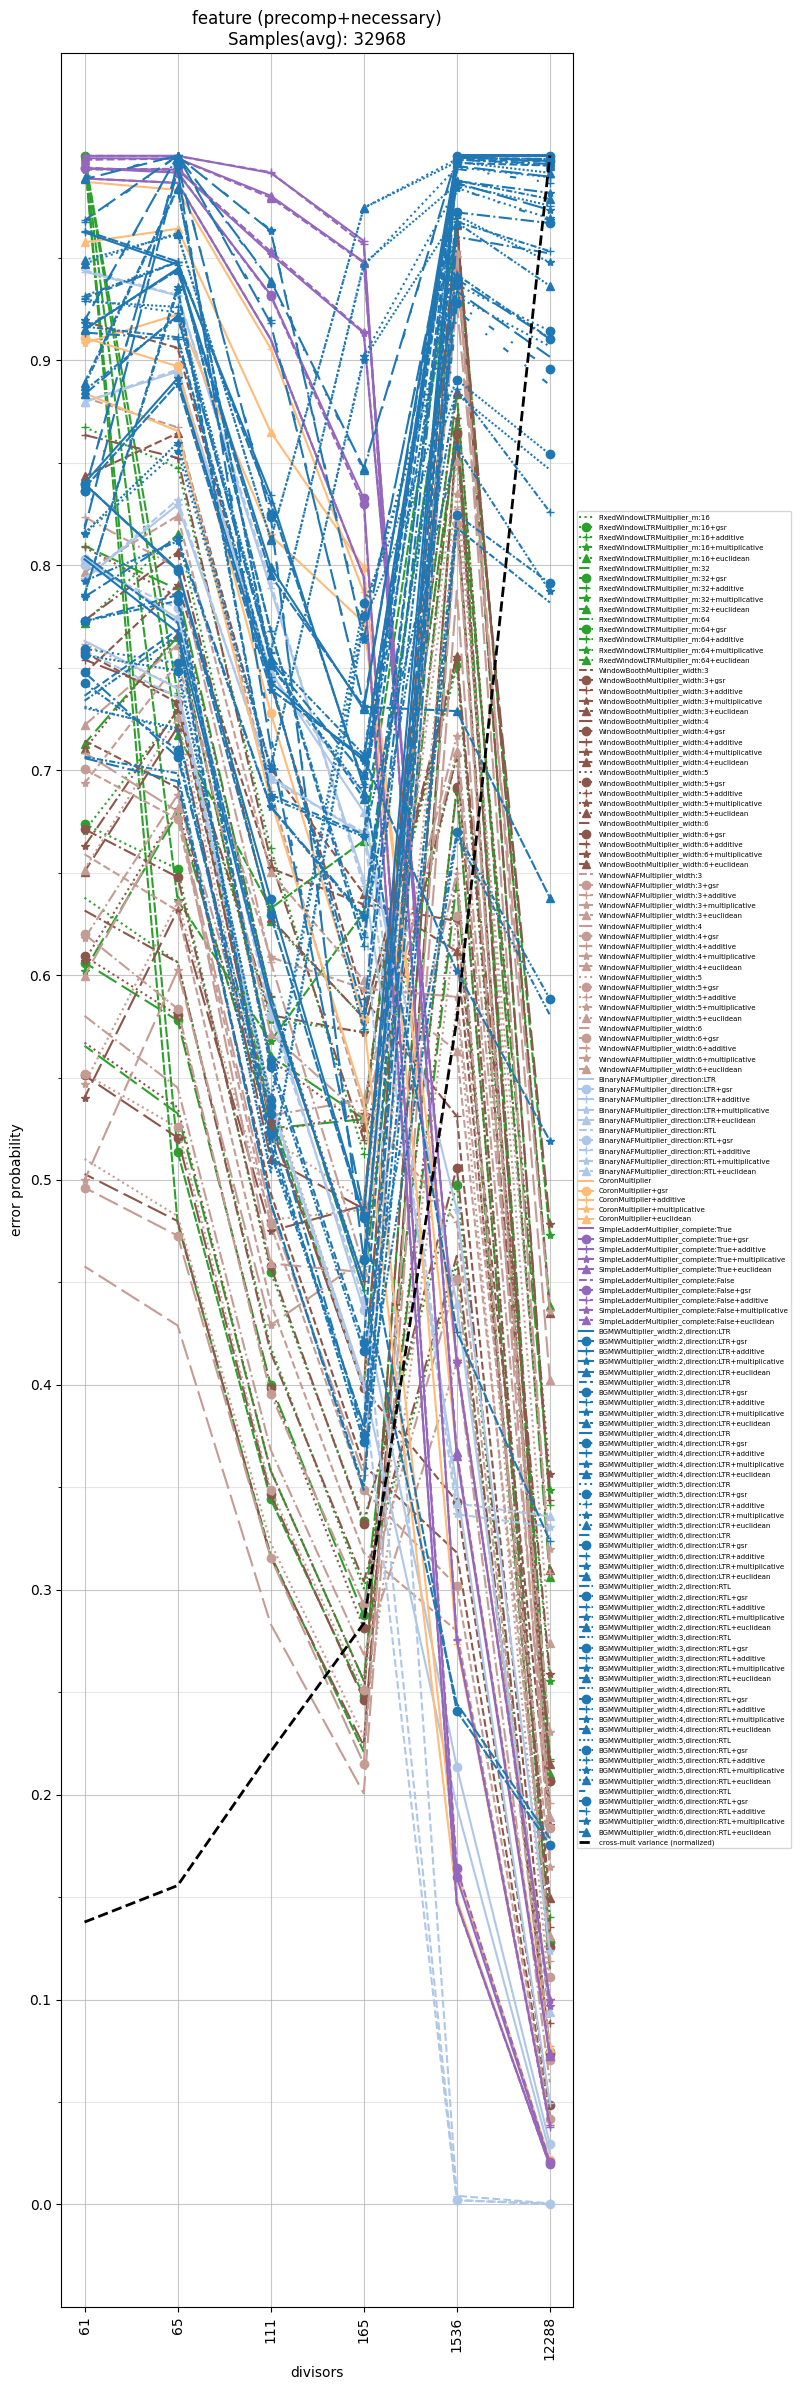

In [13]:
#divisor_name = "powers_of_2_large"
divisor_name = "feature"
plot_mults = list(filter(lambda mult: mult in distributions_mults, all_mults_with_ctr))
plot_divisors = (61, 65, 111, 165, 1536, 12288)#sorted(divisor_map[divisor_name])#[-200:]
L = len(plot_divisors)
N = len(plot_mults)
x = list(range(L))

fig = plt.figure(figsize=(L/4+5, 24))
ax = plt.subplot(111)

vals = np.zeros((N, L))
n_samples = 0
for i, mult in enumerate(plot_mults):
    probmap = distributions_mults[mult]
    y_values = [probmap[l] for l in plot_divisors]
    vals[i,] = y_values
    ax.plot(x, y_values, color=colors[mult], linestyle=styles[mult], marker=markers[mult], label=str(mult))
    if showci:
        cis = [conf_interval(p, probmap.samples) for p in y_values]
        ci_low = [ci[0] for ci in cis]
        ci_high = [ci[1] for ci in cis]
        ax.fill_between(x, ci_low, ci_high, color="black", alpha=0.1)
    n_samples += probmap.samples

ax.set_title(f"{divisor_name} ({kind})\nSamples(avg): " + str(n_samples//N))

var = np.var(vals, axis=0)
ax.plot(x, var / np.max(var), label="cross-mult variance (normalized)", ls="--", lw=2, color="black")

ax.set_xlabel("divisors")
ax.set_ylabel("error probability")
ax.set_yticks(majticks)
ax.set_yticks(minticks, minor=True)
ax.set_xticks(x, plot_divisors, rotation=90)

ax.grid(axis="y", which="major", alpha=0.7)
ax.grid(axis="y", which="minor", alpha=0.3)
ax.grid(axis="x", alpha=0.7)
plt.tight_layout()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 5})
plt.show()
fig.savefig(f"graphs/{divisor_name}-{kind}-allmults{'+ci' if showci else ''}.png", dpi=300);